In [60]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [61]:
def metricas(y_train, y_train_pred, y_test, y_test_pred):
    metricas = {
        'train': {
            'r2_score': r2_score(y_train, y_train_pred),
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'MSE': mean_squared_error(y_train, y_train_pred),
            'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
        },
        'test': {
            'r2_score': r2_score(y_test, y_test_pred),
            'MAE': mean_absolute_error(y_test, y_test_pred),
            'MSE': mean_squared_error(y_test, y_test_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))

        }
    }
    return pd.DataFrame(metricas).T

In [62]:
df = pd.read_csv("datos/target_encoding.csv", index_col = 0)

In [63]:
df.shape

(13915, 12)

In [64]:
X = df.drop("price", axis = 1)
y = df[["price"]]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Decision Tree

In [66]:
np.set_printoptions(suppress= True)
# Parámetros a evaluar
params_arbol = {
    'max_depth': [20,25],
    'min_samples_split': [15,20,30],
    'min_samples_leaf': [5,10,15],
    'max_leaf_nodes': [200,300,400]
}

In [67]:
grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, #cross validation
                                 scoring = "neg_mean_squared_error", #métrica que quiero medir
                                 n_jobs = -1) #use todos los núcleos del ordenador
grid_search_arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 25],
                         'max_leaf_nodes': [200, 300, 400],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [15, 20, 30]},
             scoring='neg_mean_squared_error')

In [68]:
modelo_final_arbol = grid_search_arbol.best_estimator_
modelo_final_arbol

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=400, min_samples_leaf=5,
                      min_samples_split=30)

In [69]:
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)

In [70]:
df_metricas_arbol = metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_arbol

,r2_score,MAE,MSE,RMSE
train,0.796431,2812.156025,1.773341e+07,4211.105994
test,0.727956,3197.446591,2.335943e+07,4833.159212


In [71]:
#plt.figure(figsize=(20,15))
#plot_tree(decision_tree= modelo_final_arbol,
#          feature_names= X.columns,
#          filled = True)

In [72]:
pd.DataFrame(grid_search_arbol.cv_results_).sort_values(by="rank_test_score", ascending=True).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.026265,0.006680,0.004440,0.002276,20,400,5,30,"{'max_depth': 20, 'max_leaf_nodes': 400, 'min_...",-2.601364e+07,-2.866898e+07,-2.458047e+07,-2.457085e+07,-2.687023e+07,-2.614083e+07,1.538785e+06,1
47,0.021770,0.001444,0.003046,0.000823,25,400,5,30,"{'max_depth': 25, 'max_leaf_nodes': 400, 'min_...",-2.601238e+07,-2.866898e+07,-2.458717e+07,-2.457085e+07,-2.687023e+07,-2.614192e+07,1.537448e+06,2


In [73]:
df_resultados_arbol = pd.DataFrame(grid_search_arbol.cv_results_)
df_resultados_arbol_filtrado = df_resultados_arbol.filter(like="param").drop(columns = "params")
df_resultados_arbol_filtrado["MSE"] = df_resultados_arbol["mean_test_score"]
df_resultados_arbol_filtrado.head(2)

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,20,200,5,15,-2.701438e+07
1,20,200,5,20,-2.699922e+07


In [74]:
df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs().reset_index())
df_rmse_prof

,param_max_depth,MSE
0,4.472136,5192.669932
1,5.000000,5192.691659


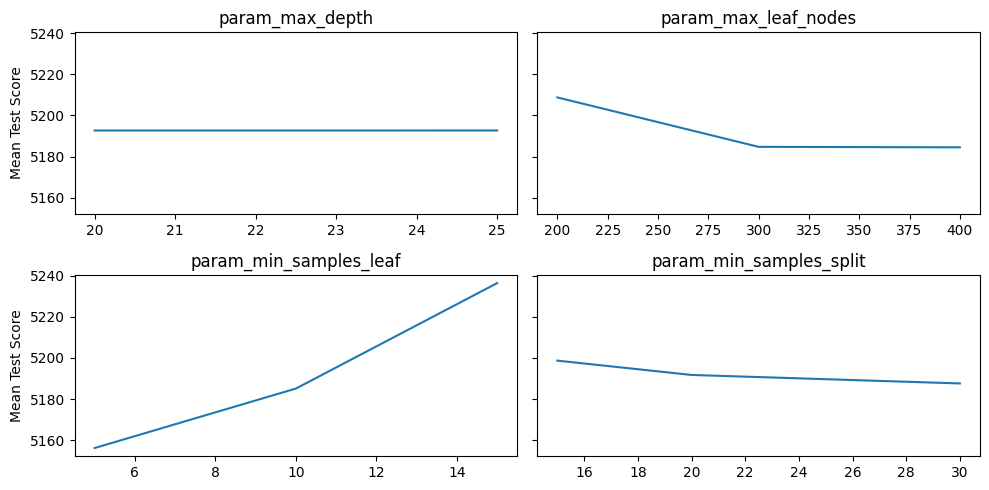

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    df_rmse_prof = (
        np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())
        .reset_index()
    )
    
    sns.lineplot(
        x=df_rmse_prof[column],
        y=df_rmse_prof["MSE"],
        ax=axes[indice]    
    )
    
    axes[indice].set_title(f"{column}")
    axes[indice].set_xlabel("")
    axes[indice].set_ylabel("Mean Test Score")

plt.tight_layout()
plt.show()

In [76]:
pd.DataFrame(modelo_final_arbol.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)

,Importancia
powerCV_robust,0.398531
kilometer_robust,0.307461
brand,0.146179
fuelType,0.065336
yearOfRegistration,0.045141
gearbox,0.016303
notRepairedDamage,0.009892
monthOfRegistration,0.009377
dateCrawled,0.000979
abtest,0.000550


## Random Forest

In [77]:
# Definimos un espacio de parámetros para optimizar
params_rf = {
    'n_estimators': [150], # de árboles que queremos en nuestro bosque
    'max_depth': [15, 20, 30],
    'min_samples_split': [15, 20, 25], # mínimo de datos que debe tener la madre
    'min_samples_leaf': [15, 20, 25], # mínimo de datos que debe tener el hijo
    'max_leaf_nodes': [100, 200, 300] # de nodos finales
}

modelo_rf = RandomForestRegressor(random_state=42, bootstrap=True) 
#bootstrap es muestreo con reemplazo, permite que el mismo dato esté en distintos árboles

grid_search_rf = GridSearchCV(modelo_rf,
                              params_rf,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_rf.fit(X_train, y_train["price"].values) #debemos pasar array de una dimensión
modelo_final_rf = grid_search_rf.best_params_

In [78]:
modelo_final_rf_dict = grid_search_rf.best_params_
modelo_final_rf_dict

{'max_depth': 20,
 'max_leaf_nodes': 300,
 'min_samples_leaf': 15,
 'min_samples_split': 15,
 'n_estimators': 150}

In [79]:
modelo_final_rf = grid_search_rf.best_estimator_
modelo_final_rf

RandomForestRegressor(max_depth=20, max_leaf_nodes=300, min_samples_leaf=15,
                      min_samples_split=15, n_estimators=150, random_state=42)

In [80]:
y_pred_test_rf = modelo_final_rf.predict(X_test)
y_pred_train_rf = modelo_final_rf.predict(X_train)

In [81]:
df_metricas_rf = metricas(y_train, y_pred_train_rf, y_test, y_pred_test_rf)
df_metricas_rf

,r2_score,MAE,MSE,RMSE
train,0.771745,2950.935082,1.988387e+07,4459.133535
test,0.743316,3132.047087,2.204056e+07,4694.737989


In [82]:
df_importancia_rf = pd.DataFrame(modelo_final_rf.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)
df_importancia_rf

,Importancia
powerCV_robust,0.343895
kilometer_robust,0.327367
brand,0.178872
fuelType,0.064933
yearOfRegistration,0.037188
gearbox,0.025319
monthOfRegistration,0.012271
notRepairedDamage,0.007035
abtest,0.002536
dateCrawled,0.000398


## Gradient Boost

In [83]:
params_gb = {
    'n_estimators': [150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [100, 200, 300] 
}

modelo_gb = GradientBoostingRegressor(random_state=42)

grid_search_gb = GridSearchCV(modelo_gb,
                              params_gb,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_gb.fit(X_train, y_train["price"].values) #debemos pasar array de una dimensión

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [15, 20, 25],
                         'min_samples_leaf': [100, 200, 300],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [150]},
             scoring='neg_mean_squared_error')

In [84]:
from joblib import dump

# Save
#vdump(grid_search_gb, 'datos/grid_search_gb.joblib')

In [85]:
# Load
#grid_search_gb = load('datos/grid_search_gb.joblib')

In [86]:
modelo_final_gb = grid_search_gb.best_estimator_
modelo_final_gb

GradientBoostingRegressor(learning_rate=0.2, max_depth=15, min_samples_leaf=100,
                          n_estimators=150, random_state=42)

In [87]:
y_pred_test_gb = modelo_final_gb.predict(X_test)
y_pred_train_gb = modelo_final_gb.predict(X_train)

In [88]:
df_metricas_gb = metricas(y_train, y_pred_train_gb, y_test, y_pred_test_gb)
df_metricas_gb

,r2_score,MAE,MSE,RMSE
train,0.847943,2414.349768,1.324607e+07,3639.514427
test,0.788716,2834.635999,1.814220e+07,4259.365655


## XGBoost Regressor

In [89]:
params_xgb = {
    'max_depth': [15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [150],
    'min_child_weight': [1, 2, 4],
    'colsample_bytree': [0.8, 1.0]   
}

modelo_xgb = XGBRegressor(random_state=42)

grid_search_xgb = GridSearchCV(modelo_xgb,
                              params_xgb,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [15, 20, 25],
                         'min_child_weight': [1, 2, 4], 'n_estimators': [150]},
             scoring='neg_mean_squared_error')

In [90]:
modelo_final_xgb = grid_search_xgb.best_estimator_
modelo_final_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [91]:
y_pred_test_xgb = modelo_final_xgb.predict(X_test)
y_pred_train_xgb = modelo_final_xgb.predict(X_train)

In [92]:
df_metricas_xgb = metricas(y_train, y_pred_train_xgb, y_test, y_pred_test_xgb)
df_metricas_xgb

,r2_score,MAE,MSE,RMSE
train,0.971771,919.394264,2.459081e+06,1568.145617
test,0.781140,2781.165490,1.879274e+07,4335.058831
